# How Can Feet Make an Earthquake?
## Motivation
On June 17, 2018, the Twitter account of the _Instituto de Investigaciones Geológicas y Atmosféricas_ (IIGEA) tweeted that they detected an artificial seismic event in Mexico City, at a timestamp perfectly corresponding to the winning goal of the Mexico - Germany game in the 2018 World Cup (https://twitter.com/SIMMSAmex/status/1008374780351967233).


The prevailing speculation is that the feet of Mexico City – all 18 million of them – jumped with excitement when that goal was scored, literally making the ground shake.  This is a reasonable hypothesis:  Since the IIGEA sent their tweet, several other examples of small seismic events corresponding with sports highlights have surfaced.

But this suggests a question:  So many people stamping their feet would all be out of phase with each other.  It would seem that on average, the stamping should all cancel out.  But the seismograph says otherwise.  Apparently, when you add a bunch of waves of random phases, they add constructively.  What's the deal?


## Toy Model
For a toy model to investigate this, we'll model the wave detected at the seismograph as the sum of many simple sine waves of unit frequency and amplitude.  We can make these assumptions for the following reasons:  The waves are propagating through a reasonably uniform medium, so they'll all be basically traveling at the same speed.  The amplitudes will be in a small range around how hard humans can stomp up and down.  These assumptions will turn out not to matter; the math will work out the same.

First, we can just quickly see if adding randomly-phased signals can produce something that's not canceled out:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as st
st.use('ggplot')

In [2]:
x = np.arange(0, 4 * np.pi, 0.01)
phases = np.random.random(100) * 2 * np.pi
sinewave = np.sin(x)
randomphase = np.zeros_like(x)
for phase in phases:
    randomphase += np.sin(x + phase)

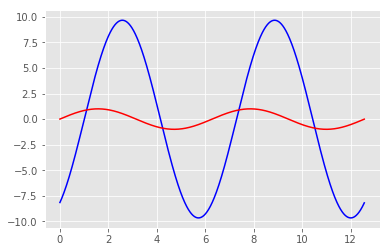

In [3]:
plt.plot(x, randomphase, c = 'blue')
plt.plot(x, sinewave, c = 'red')
plt.show()

Sure enough.  That's definitely a bigger amplitude signal than the unadulterated unit sine wave (in red).  One thing we're interested in is whether an amplitude of 4 is some sort of equilibrium, or if it changes with the number of additional signals.  If it's the latter, then it would suggest that after reaching this equilibrium, the signals do cancel out.  If it's instead the case that it grows with the number of additional signals, then there's another mechanism afoot.

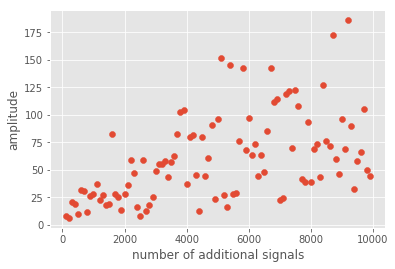

In [4]:
peaks = []
x = np.arange(0, 4 * np.pi, 0.01)
for n in np.arange(100, 10000, 100):
    phases = np.random.random(n) * 2 * np.pi
    signal = np.zeros_like(x)
    for phase in phases:
        signal += np.sin(x + phase)
    peaks.append(np.max(signal))
plt.scatter(np.arange(100, 10000, 100), peaks)
plt.ylabel('amplitude')
plt.xlabel('number of additional signals')
plt.show()

So the amplitude of the aggregate signal does grow with the number of signals you add, but it does slowly, and the relationship isn't very clear.

To reiterate, we're asking what the amplitude will be, on average, when you add many sinusoids together.  More rigorously, what is the expected amplitude of the signal $\mathcal{S}$ which is the sum of $N$ sinusoids of unit amplitude and random phase? Or, in math:

\begin{equation}
\mathcal{S} = \sum_{j}^N \sin\left(t + \phi_j \right),
\end{equation}

for phase $\phi$ and time $t$.

This looks terrible to solve, and phases add in a really convoluted way with an arctangent, sines and cosines, and it's just not a good way to do things.

This suggests that we should look at the problem a different way.

## Casting the problem in amplitude-phase space
In this problem, we really only care about comparing the amplitude of the signals with their phases.  The other variable, time, is not something we really actually care about:  All of the signals are occuring simultaneously.

Amplitude and phase are a length and an angle, respectively.  This suggests that a natural way to express them is as complex numbers, with each signal's amplitude being represented by the magnitude of the complex number and the phase contributing the imaginary part.

So, a signal with amplitude 1 and a phase of $\pi/4$ would be represented by the complex number $e^{i\pi/4}$:


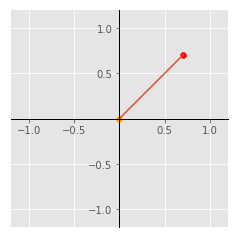

In [5]:
phases = [np.pi/4]
points = np.zeros((len(phases) + 1, 2))
points[0] = np.array([0,0])
for i in range(len(phases)):
    points[i, 0] = points[i - 1, 0] + np.cos(phases[i])
    points[i, 1] = points[i - 1, 1] + np.sin(phases[i])
plt.plot(points[:,0],points[:,1])
plt.scatter(points[0,0],points[0,1],c='red')
plt.scatter(points[-1,0],points[-1,1],c='orange')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
ax = plt.gca()
ax.spines['left'].set_position('center')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.set_xticks([-1,-0.5,0.5,1])
ax.set_yticks([-1,-0.5,0.5,1])
ax.set_aspect(1)
plt.show()


Now, the sum in equation 1 becomes a sum on exponentials:
\begin{equation}
\mathcal{S} = \sum_{j}^N e^{i\phi_j},
\end{equation}

and the question of what the final amplitude is becomes, what the final magnitude is of the complex number you get from this sum.  This is \emph{much} easier:  You just measure how far you are from the origin!

There's one final piece, and it comes from watching what happens when you sum together a bunch of random vectors of unit length:


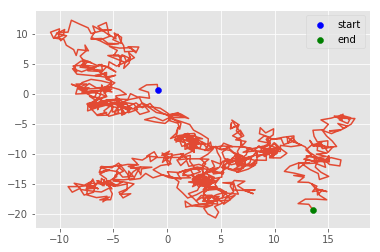

In [6]:
phases = np.random.random(1000) * 2 * np.pi
points = np.zeros((len(phases), 2))
for i in range(len(phases)):
    points[i, 0] = points[i - 1, 0] + np.cos(phases[i])
    points[i, 1] = points[i - 1, 1] + np.sin(phases[i])
plt.plot(points[:,0], points[:,1])
plt.scatter(points[0,0], points[0,1], c='blue', zorder=100, label='start')
plt.scatter(points[-1,0], points[-1,1], c='green', zorder=100, label='end')
plt.legend()
plt.show()

It's just a random walk in this vector space!  This is terrific because we already know \emph{everything} about how random walks propagate.  They follow well-established statistics.  I'll go through one derivation below.

So to find the expected amplitude of the final signal, you just need to find the length of (2) after some finite $N$.  The length of a complex number is the square root of the complex number squared.  It's easier to work with the square for now:

\begin{align}
|\mathcal{S}|^2 &= \sum_{j}^N e^{i \phi_j}\sum_{k}^N e^{-i \phi_k},\\
&= \sum_{j}^N \sum_{k}^N e^{i \left(\phi_j -\phi_k\right)}.
\end{align}

These sums are non-trivial for all except the case that $j = k$, where the exponent vanishes, leaving 1 in the sum.  So, we can collapse the double sum like so:
\begin{equation}
|\mathcal{S}|^2 = N + \sum_{j \neq k}^N e^{i \left(\phi_j -\phi_k\right)}.
\end{equation}

Now, the sum in the second half of (5) behaves exactly like we expected the sum to behave at the start of this whole question:  It's a flat distribution on either side of $\pi$, so it averages out to 0.  This leaves the expected length of the final complex number as 

\begin{equation}
|\mathcal{S}| = \sqrt{N}.
\end{equation}
And that's it!  The more signals you add, the louder your ultimate signal gets, and it goes as the square root of the number of additions, and it totally agrees with what the computer was saying earlier!  I think that's fantastic.


Incidentally, this explains the general shape of the distriubtion of amplitudes as the number of additional signals increased:


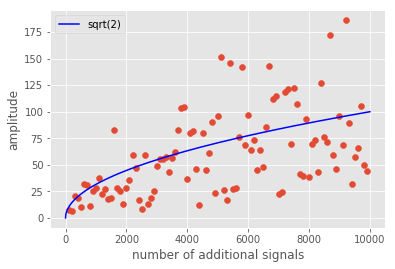

In [7]:
plt.scatter(np.arange(100, 10000, 100), peaks)
plt.plot(np.sqrt(np.arange(10000)), c='blue', label='sqrt(2)')
plt.ylabel('amplitude')
plt.xlabel('number of additional signals')
plt.legend()
plt.show()

## Conclusion

I really like this problem for a number of reasons.  First, it's always satisfying when a slight change in perspective makes everything fall into place.  I find this solution particularly neat.

Second, this is related to so many phenomena:  Why are rooms with lots of people really noisy?  Why does violent thrashing in a swimming pool create big waves?  Why do multiple light sources never cancel out in a house?  All of these are ultimately the messy combination of many out-of-phase signals.
